## Group: The Order of the PyTorch
### Milestone 1

- Members: Onur Buyukkalkan, Yi-Huai Chang, Diyanet Nijiati

- Project: Costa Rica Household Poverty Prediction

https://www.kaggle.com/competitions/costa-rican-household-poverty-prediction/overview 

In [59]:
#after initial exploration

# 0. cleaning phase
    #handle null valus
    #convert text to numeric values (edjefe, edjefa)
# 1. Create features (dependency rate, asset index, education index, ....
# 2. average household characteristics / representative(head) V
    # round target label
# 3. Generate synthetic data using Smote to balance data
    # 3.1 standardize data V
#### 4. Ensemble Modeling(to predict)not for now for the final paper

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

## Step 1: Initial Exploration

In [61]:
#Load and Explore the Data
data = pd.read_csv('train.csv')
print(data.head())
print(data.describe())

             Id      v2a1  hacdor  rooms  hacapo  v14a  refrig  v18q  v18q1  \
0  ID_279628684  190000.0       0      3       0     1       1     0    NaN   
1  ID_f29eb3ddd  135000.0       0      4       0     1       1     1    1.0   
2  ID_68de51c94       NaN       0      8       0     1       1     0    NaN   
3  ID_d671db89c  180000.0       0      5       0     1       1     1    1.0   
4  ID_d56d6f5f5  180000.0       0      5       0     1       1     1    1.0   

   r4h1  ...  SQBescolari  SQBage  SQBhogar_total  SQBedjefe  SQBhogar_nin  \
0     0  ...          100    1849               1        100             0   
1     0  ...          144    4489               1        144             0   
2     0  ...          121    8464               1          0             0   
3     0  ...           81     289              16        121             4   
4     0  ...          121    1369              16        121             4   

   SQBovercrowding  SQBdependency  SQBmeaned  agesq  Tar

In [62]:
#Checking Shape and NA Values Across Columns
print("Data shape:", data.shape)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None) 
print(data.isnull().sum())

#v2a1, v18q1, rez_esc have too many null values, is this a problem?

Data shape: (9557, 143)
Id                    0
v2a1               6860
hacdor                0
rooms                 0
hacapo                0
                   ... 
SQBovercrowding       0
SQBdependency         0
SQBmeaned             5
agesq                 0
Target                0
Length: 143, dtype: int64


In [63]:
#Counts of the Target Labels
print(data['Target'].value_counts())

Target
4    5996
2    1597
3    1209
1     755
Name: count, dtype: int64


## Step 2: Plotting

We should now visualize the data

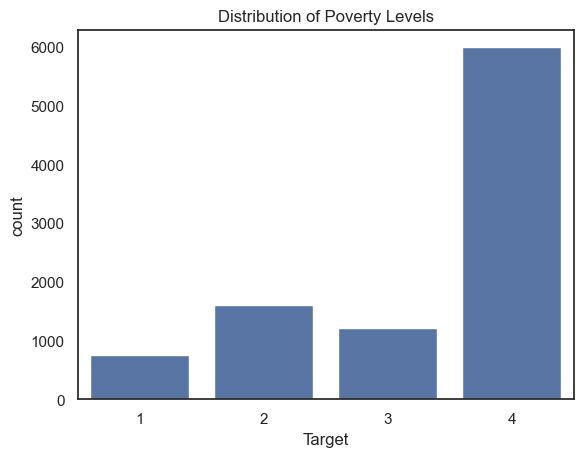

In [64]:
# Plotting the distribution of the poverty levels
sns.countplot(x='Target', data=data)
plt.title('Distribution of Poverty Levels')
plt.show()

#https://imbalanced-learn.org/stable/over_sampling.html


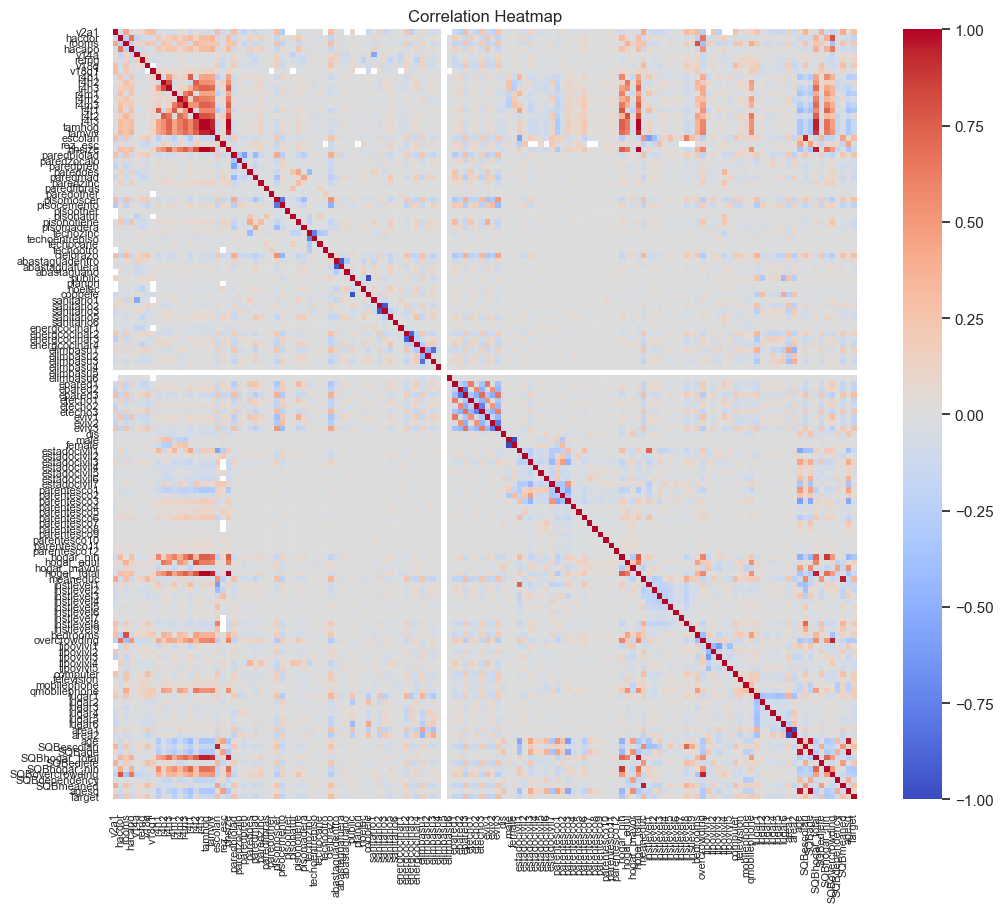

In [65]:
# Select only numeric columns for correlation matrix
numeric_data = data.select_dtypes(include=[np.number])  # np.number covers integers and floats

# Now compute the correlation matrix
corr_matrix = numeric_data.corr()

# Assuming 'corr_matrix' is your correlation matrix
sns.set(style="white")  # Set style to 'white' to ensure labels are clear

plt.figure(figsize=(12, 10))  # Adjust figure size to your preference
ax = sns.heatmap(
    corr_matrix,
    annot=False,
    cmap='coolwarm',
    cbar=True,
    xticklabels=True,
    yticklabels=True
)

# Rotate the labels on the x-axis for better visibility
plt.xticks(rotation=90, fontsize=8)  # Rotate x labels and set font size
plt.yticks(rotation=0, fontsize=8)  # Rotate y labels and set font size (if needed)

plt.title('Correlation Heatmap')
plt.show()

#We see that hhsize, tamhog, r4t3,hogar_total are the same thing by looking at the heatmap

## Step 3: Data Cleaning

We can fill n/a values with mean for consistency or maybe just drop all n/a values.

In [66]:
# Check for missing values
missing_data = data.isnull().sum()
missing_data = missing_data[missing_data > 0]
print(missing_data.sort_values(ascending=False))

# Impute missing values with the median
for column in missing_data.index:
    if data[column].dtype != 'object':  # assuming only numeric columns need imputation
        data[column].fillna(data[column].median(), inplace=True)

# Dropping columns with more than 70% missing values
for column in missing_data.index:
    if missing_data[column] > 0.7 * len(data):
        data.drop(columns=[column], inplace=True)


rez_esc      7928
v18q1        7342
v2a1         6860
meaneduc        5
SQBmeaned       5
dtype: int64


/var/folders/hm/_pzcf0b141vbjfjkskxh1x9h0000gn/T/ipykernel_18326/253303462.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[column].fillna(data[column].median(), inplace=True)
/var/folders/hm/_pzcf0b141vbjfjkskxh1x9h0000gn/T/ipykernel_18326/253303462.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting value

In [67]:
# Text Features to Integers
# Convert edjefe and edjefa to dummy variables


## Step 4: Feature Selection

The features that are available to us are described here: https://www.kaggle.com/competitions/costa-rican-household-poverty-prediction/data

We have a number of different features from material amenities like toilet and source of electricity to household characteristics like disability, number of kids, years in education etc. These are indirect features that might reflect the quality of life for these households.

We can use the outside wall material, roof material, number of tablets owned, toilet situation, electricity source etc. We can also create children to adult ratio, income per children, income per person in household, but we do not have income data. We can therefore find replacements that will still represent the level of income. 

#### Potential New Features 

- **Ratio of Children to Adults**: This can highlight households that may be under more financial strain.

- **Dependency Ratio**: Although it’s already provided, checking for its accurate calculation or recalculating might be useful if there are any discrepancies.

- **Asset Index**: Create a composite score based on the presence of assets (e.g., refrigerator, computer, tablet, TV) and home characteristics (types of walls, floors, and roof materials). This score can serve as a proxy for economic status.

- **Educational Level Index**: A score representing the overall educational attainment within the household.

#### Limitations

- Underreporting or overreporting to get financial assistance.
- Lack of monetary income and asset reported.
- Dimensionality problem might arise if we fail to find the most important features and eliminate the lesser important ones.

In [68]:
# Make your own dependency rate
#???????????????????????


In [69]:
#Trying Out Indexes

# Example of creating an Asset Index
data['asset_index'] = (data['refrig'] + data['v18q'] + data['computer'] + data['television'] + data['mobilephone']).astype(int)

# Example of creating an Educational Level Index
data['education_index'] = (data['instlevel1'] + data['instlevel2']*2 + data['instlevel3']*3 + data['instlevel4']*4 + data['instlevel5']*5 + data['instlevel6']*6 + data['instlevel7']*7 + data['instlevel8']*8 + data['instlevel9']*9)


In [70]:
### Convert everything to numeric if necessary
# Select only numeric columns
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns

# Exclude 'Target' from numeric columns, now safely assuming all are numeric
numeric_cols = numeric_cols.drop('Target', errors='ignore')  # Use errors='ignore' to avoid KeyErrors if the column is not present
#Group by idhogar
data = data.groupby('idhogar')[numeric_cols].mean()
#Group by household before or after prediction, rounding the final label up and down for each household mean to find the target label?

# Display the result
print(data.head())

#we gotta round the target to nearest integer

           hacdor  rooms  hacapo  v14a  refrig  v18q  r4h1  r4h2  r4h3  r4m1  \
idhogar                                                                        
001ff74ca     0.0    6.0     0.0   1.0     1.0   1.0   0.0   0.0   0.0   1.0   
003123ec2     0.0    3.0     0.0   1.0     1.0   0.0   2.0   1.0   3.0   0.0   
004616164     0.0    4.0     0.0   1.0     1.0   0.0   0.0   2.0   2.0   0.0   
004983866     0.0    5.0     0.0   1.0     1.0   0.0   0.0   1.0   1.0   0.0   
005905417     0.0    8.0     0.0   1.0     0.0   0.0   1.0   1.0   2.0   0.0   

           ...       SQBage  SQBhogar_total  SQBedjefe  SQBhogar_nin  \
idhogar    ...                                                         
001ff74ca  ...   722.000000             4.0        0.0           1.0   
003123ec2  ...   278.750000            16.0       36.0           4.0   
004616164  ...  1378.000000             4.0        9.0           1.0   
004983866  ...  1868.500000             4.0        0.0           1.0   
0059054

In [71]:
### Convert everything to numeric if necessary
# Select only numeric columns
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns

# Exclude 'Target' from numeric columns, now safely assuming all are numeric
numeric_cols = numeric_cols.drop('Target', errors='ignore')  # Use errors='ignore' to avoid KeyErrors if the column is not present

In [72]:
#Standardization

from sklearn.preprocessing import StandardScaler

# Create a scaler object
scaler = StandardScaler()

# Fit the scaler and transform the data
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

# Check the transformed data
print(data[numeric_cols].head())


             hacdor     rooms    hacapo     v14a    refrig      v18q  \
idhogar                                                                
001ff74ca -0.147945  0.834580 -0.110432  0.07785  0.223371  1.887282   
003123ec2 -0.147945 -1.230902 -0.110432  0.07785  0.223371 -0.529863   
004616164 -0.147945 -0.542408 -0.110432  0.07785  0.223371 -0.529863   
004983866 -0.147945  0.146086 -0.110432  0.07785  0.223371 -0.529863   
005905417 -0.147945  2.211568 -0.110432  0.07785 -4.476858 -0.529863   

               r4h1      r4h2      r4h3      r4m1  ...    SQBage  \
idhogar                                            ...             
001ff74ca -0.473142 -1.414611 -1.472373  1.269044  ... -0.807769   
003123ec2  3.110502 -0.322682  1.359892 -0.472758  ... -1.086609   
004616164 -0.473142  0.769247  0.415803 -0.472758  ... -0.395092   
004983866 -0.473142 -0.322682 -0.528285 -0.472758  ... -0.086527   
005905417  1.318680 -0.322682  0.415803 -0.472758  ... -0.998590   

           SQBhoga

In [73]:
# Split the data into 70% training and 30% temporary set
train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42)

# Split the temporary set into 10% validation and 20% test set
# Since the temp_data is 30% of the data, we take 1/3 of it for validation (which is 10% of the total data)
validation_data, test_data = train_test_split(temp_data, test_size=2/3, random_state=42)


In [74]:
print("Training set size: ", train_data.shape)
print("Validation set size: ", validation_data.shape)
print("Test set size: ", test_data.shape)


Training set size:  (2091, 136)
Validation set size:  (299, 136)
Test set size:  (598, 136)
